In [1]:
'''
random_forest.py = here we build a random forest model to run over the K-fold CV
  Copyright (c) 2023 Charlie Payne
  Licence: GNU GPLv3
DESCRIPTION
  this notebook builds the optimal random forest model via the OptimalRF class
  it then runs the model for the dataset of your choice
NOTES
  [none]
RESOURCES
  -- https://www.datacamp.com/tutorial/random-forests-classifier-python
CONVENTIONS
  [none]
KNOWN BUGS
  [none]
DESIRED FEATURES
  [none]
'''

import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [2]:
class OptimalRF():
    '''
    CLASS: OptimalRF = this finds the optimal random forest model via a grid search method
    '''
    def __init__(self, X_train: np.ndarray, X_test: np.ndarray, y_train: pd.DataFrame, y_test: pd.DataFrame, nest: int, maxd: int, score: str) -> None:
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        
        self.nest = nest
        self.maxd = maxd
        self.score = score
    
    def find_best_rf(self):
        '''
        METHOD: find_best_rf = this method builds the RandomizedSearchCV() to find the optimal parameters for the random forest
        '''
        param_dist = {'n_estimators': randint(1, self.nest), 'max_depth': randint(1, self.maxd)}
        
        rf = RandomForestClassifier(class_weight="balanced")
        rand_search = RandomizedSearchCV(rf,
                                         param_distributions=param_dist,
                                         scoring=self.score,
                                         n_iter=15,
                                         cv=5)
        
        rand_search.fit(self.X_train, self.y_train['class'])
        
#         self.best_est = rand_search.best_estimator_
        self.best_params = rand_search.best_params_
        print('Best hyperparameters:', self.best_params)
    
    def train_best_rf(self):
        '''
        METHOD: train_best_rf = after find_best_rf, we now train the optimal random forest using the optimal parameters
        '''
        self.rf_best = RandomForestClassifier(max_depth=self.best_params['max_depth'], n_estimators=self.best_params['n_estimators'])
        self.rf_best.fit(self.X_train, self.y_train['class'])
    
    def make_prediction(self):
        '''
        METHOD: make_prediction = now make a prediction on the test data with the optimal random forest model
        '''
        self.y_pred = self.rf_best.predict(self.X_test)
    
    def calc_scores(self):
        '''
        METHOD: calc_scores = calculate the accuracy, precision, recall, and F1-score
        '''
        self.accuracy = accuracy_score(self.y_test['class'], self.y_pred)
        self.precision = precision_score(self.y_test['class'], self.y_pred)
        self.recall = recall_score(self.y_test['class'], self.y_pred)
        self.f1 = 2*self.precision*self.recall/(self.precision + self.recall)
        
        print("Accuracy =", self.accuracy)
        print("Precision =", self.precision)
        print("Recall =", self.recall)
        print("F1 =", self.f1, '\n')
    
    def print_confusion_matrix(self):
        '''
        METHOD: print_confusion_matrix = construct the confusion matrix on the test prediction
        '''
        cm = confusion_matrix(self.y_test['class'], self.y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    
    def run(self):
        '''
        METHOD: run = run all the methods in order
        '''
        self.find_best_rf()
        self.train_best_rf()
        self.make_prediction()
        self.calc_scores()
        self.print_confusion_matrix()

In [3]:
def control_metrics(y_test: pd.DataFrame) -> [float, float, float, float]:
    '''
    FUNCTION: control_metrics = calculate the metrics assuming we predict only 1's, this acts as a control
          IN: y_test = the dataframe from the input data
    '''
    num_HC = len([val for val in y_test['class'] if val == 0])
    num_PD = len([val for val in y_test['class'] if val == 1])

    # assume predict only 1's, these values should be beaten by the random forest model's average metrics
    control_accuracy = (num_PD + 0)/(num_PD + num_HC + 0 + 0)  # (TP + TN)/(TP + FP + TN + FN)
    control_precision = num_PD/(num_PD + num_HC)  # TP/(TP + FP)
    control_recall = num_PD/(num_PD + 0)  # TP/(TP + FN)
    control_f1 = 2*control_precision*control_recall/(control_precision + control_recall)

    print("Control Accuracy =", control_accuracy)
    print("Control Precision =", control_precision)
    print("Control Recall =", control_recall)
    print("Control F1 =", control_f1)
    
    return control_accuracy, control_precision, control_recall, control_f1

In [4]:
# use this and the next cell to run a single test_train_split or single fold

front_dir = '../data/split'

X_train = np.loadtxt(front_dir + '/X_train.csv', delimiter=',')
X_test = np.loadtxt(front_dir + '/X_test.csv', delimiter=',')
y_train = pd.read_csv(front_dir + '/y_train.csv', index_col=0)
y_test = pd.read_csv(front_dir + '/y_test.csv', index_col=0)

print('---- X_train ----')
print(X_train, '\n')
print('---- X_test ----')
print(X_test, '\n')
print('---- y_train ----')
display(y_train)
print('---- y_test ----')
display(y_test)

---- X_train ----
[[ 0.       0.81206  0.8146  ... 16.8685  24.9648  84.2961 ]
 [ 1.       0.83109  0.65411 ...  4.0824   3.7854   4.5031 ]
 [ 0.       0.80262  0.80754 ...  2.3387   2.3601   3.4241 ]
 ...
 [ 1.       0.82878  0.67313 ... 56.3617  46.9699  91.769  ]
 [ 1.       0.79163  0.80358 ...  3.2119   6.2882  28.9917 ]
 [ 0.       0.80207  0.755   ...  3.4054   3.0892   3.922  ]] 

---- X_test ----
[[  0.        0.79982   0.72944 ...   2.7642    3.0253    2.9772 ]
 [  0.        0.85659   0.6008  ...   3.0633    2.4542    9.6152 ]
 [  1.        0.7988    0.75823 ...  23.5786   20.9462  120.3172 ]
 ...
 [  1.        0.79262   0.74223 ...  33.8718   37.5307   92.3335 ]
 [  0.        0.86082   0.81274 ...   4.8766    6.3808   65.2151 ]
 [  1.        0.81369   0.79407 ...   5.9697    7.4155   14.3145 ]] 

---- y_train ----


,class
477,1
101,0
225,0
198,1
574,1
...,...
399,1
163,1
24,1
374,1


---- y_test ----


,class
210,1
357,0
326,1
340,1
418,1
...,...
86,1
527,1
129,1
247,1


Control Accuracy = 0.743421052631579
Control Precision = 0.743421052631579
Control Recall = 1.0
Control F1 = 0.8528301886792453

Best hyperparameters: {'max_depth': 5, 'n_estimators': 158}
Accuracy = 0.868421052631579
Precision = 0.8661417322834646
Recall = 0.9734513274336283
F1 = 0.9166666666666666 

CPU times: user 44.7 s, sys: 208 ms, total: 44.9 s
Wall time: 45.1 s


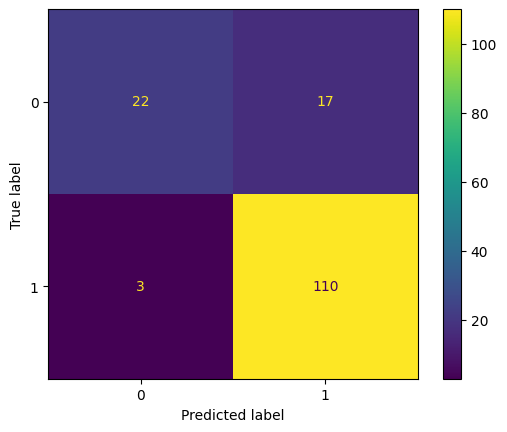

In [19]:
%%time

n_est = 200  # maximum number of trees in the random forest to optimize over
max_d = 20   # maximum depth of said trees to optimize over
metric = 'balanced_accuracy'  # the scoring for RandomizedSearchCV()

control_metrics(y_test)
print('')
orf = OptimalRF(X_train, X_test, y_train, y_test, n_est, max_d, metric)
orf.run()

In [20]:
# run the above cell three times, record the numbers and find the average - there's stochasicity in RandomizedSearchCV()

print("---- metric = 'accuracy' ----")
print("AVG Accuracy =", (0.8289473684210527 + 0.8618421052631579 + 0.8486842105263158)/3)
print("AVG Precision =", (0.8372093023255814 + 0.8650793650793651 + 0.8571428571428571)/3)
print("AVG Recall =", (0.9557522123893806 + 0.9646017699115044 + 0.9557522123893806)/3)
print("AVG F1 =", (0.8925619834710744 + 0.9121338912133892 + 0.9037656903765691)/3)

print("\n---- metric = 'balanced_accuracy' ----")
print("AVG Accuracy =", (0.8486842105263158 + 0.8355263157894737 + 0.868421052631579)/3)
print("AVG Precision =", (0.8515625 + 0.84375 + 0.8661417322834646)/3)
print("AVG Recall =", (0.9646017699115044 + 0.9557522123893806 + 0.9734513274336283)/3)
print("AVG F1 =", (0.904564315352697 + 0.8962655601659751 + 0.9166666666666666)/3)

print("\n---- metric = 'recall' ----")
print("AVG Accuracy =", (0.868421052631579 + 0.875 + 0.8618421052631579)/3)
print("AVG Precision =", (0.8661417322834646 + 0.873015873015873 + 0.8650793650793651)/3)
print("AVG Recall =", (0.9734513274336283 + 0.9734513274336283 + 0.9646017699115044)/3)
print("AVG F1 =", (0.9166666666666666 + 0.9205020920502092 + 0.9121338912133892)/3)

---- metric = 'accuracy' ----
AVG Accuracy = 0.8464912280701755
AVG Precision = 0.8531438415159346
AVG Recall = 0.9587020648967552
AVG F1 = 0.902820521687011

---- metric = 'balanced_accuracy' ----
AVG Accuracy = 0.850877192982456
AVG Precision = 0.8538180774278216
AVG Recall = 0.9646017699115044
AVG F1 = 0.9058321807284462

---- metric = 'recall' ----
AVG Accuracy = 0.8684210526315789
AVG Precision = 0.8680789901262344
AVG Recall = 0.9705014749262536
AVG F1 = 0.9164342166434216


In [ ]:
# F- I-- N---